# Optimisation pour le Machine Learning - Projet
## Predire la température d'un moteur de voiture - Théo Delemazure


Ce notebook résume mon projet pour le cours d'*optimisation pour le machine learning* qui se base sur le dataset **Electric Motor Temperature** de **Kaggle** ([https://www.kaggle.com/wkirgsn/electric-motor-temperature/data](https://www.kaggle.com/wkirgsn/electric-motor-temperature/data)). Ce dataset contient des mesures de différents capteurs sur un moteur électrique de type *permanent magnet synchronous motor (PMSM)*. Les données sont réparties sur **52 sessions** de conduites, pour un total de **140 heures** avec les mesures enregistrées à une fréquence de **2 Hz**. 

Mesurer directement la température du moteur et des stator étant couteux car nécessitant des techniques complexes, **notre but sera de prédire leurs valeurs** en fonction des autres mesures, moins couteuse, comme la vitesse ou le Voltage de certaines pièces.

In [75]:
import time
import csv
import sys
import getopt
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

# I. Lecture des données

La première étape consiste à charger les données, et les séparer en données à utiliser pour les prédictions et données à prédire, puis de séparer le *test set* du *train set*.

Ci-dessous, le code pour **charger les données** :

In [76]:
f = open("./pmsm_temperature_data.csv")
spamreader = csv.reader(f)
i = 0
n = 998070
p_tot = 13
p_in = 7
p_out = 4
X = np.zeros((n,p_tot))
for row in spamreader:
    if i == 0:
        Xlabels = row[::]
    else:
        for j in range(len(row)):
            X[i-1,j] = float(row[j])
    i += 1
Xlabels = np.array(Xlabels)

On récupère ici les identifiants des sessions et une fonction utile pour récupérer **uniquement** les données d'une ou de plusieurs sessions en particulier :

In [77]:
sess_id = np.unique(X[:,-1])
n_ses = len(sess_id)

def get_session(X,ids):
    if type(ids) == int:
        ids = [ids]
    X_out = []
    for i,x in enumerate(X):
        if x[-1] in ids:
            X_out.append(x)
    return np.array(X_out)

print("Nombre de sessions :",n_ses)

Nombre de sessions : 52


Pour séparer le *train set* du *test set*, il faut faire attention à ne pas séparer les données totalement au hasard. En effet, les mesures de chaque paramètre lors d'une session étant très proches, les données de tests ne seront **pas du tout indépendantes** des données de train (ce qui pose problème). On choisit alors **30** sessions parmi **52** au hasard pour le *train* et le reste des sessions est utilisée comme *test*.

Une fois cette séparation faite, on peut **mélanger** les données d'entrainement pour séparer les données provenant d'une même session.

In [78]:
# On selectionne les session de test et de train
Itrain = np.random.choice(sess_id,30,replace=False)
Itest =  np.setdiff1d(sess_id,Itrain)

#On récupère les données de test et de train
data_train = get_session(X,Itrain)
data_test = get_session(X,Itest)

# On mélange les données d'entrainement
np.random.shuffle(data_train)

Il faut encore séparer les données en **données à prédire** et **données pour prédire**. Les données à prédire proposées sont les suivantes selon le détenteur du dataset :

- **torque** : Le couple induit par le courant. Il est compliqué à mesurer mais facile à déduire du courant, donc *nous ne chercherons pas à le prédire ici*.
- **pm** : La température du rotor. Il est compliqué à mesurer (thermographie infrarouge), il est donc intéressant de pouvoir le prédire afin d'éviter une surchauffe.
- **stator_yoke** : La mesure de la température de la culasse du stator.
- **stator_tooth** : La mesure de la température de la dent du stator.
- **stator_winding** : La mesure de la température du bobinage du stator.

Les données utilisées pour les prédictions sont toutes les autres (hormis l'identifiant de la session) :

- **ambiant** : Mesure de la température ambiante.
- **coolant** : Mesure de la température du liquide de refroidissement.
- **u_d** et **u_q** : Voltage du *d-component* et du *q-component*.
- **motor speed** : Mesure de la vitesse du moteur.
- **i_d** et **i_q** : Courant dans le *d-component* et le *q-component*.

In [79]:
x_att = np.array([0,1,2,3,4,6,7])
y_att = np.array([8 ,9,10,11])
X_train = data_train[:,x_att]
X_test = data_test[:,x_att]
Y_train = data_train[:,y_att]
Y_test = data_test[:,y_att]

Les données sont déjà normalisées, ce n'est donc pas nécessaire de les normaliser à nouveau. On ajoute également un vecteur rempli de 1 aux données d'entrée pour **prendre en compte le biais**.

In [80]:
X_train = np.concatenate([X_train,np.ones((len(X_train),1))],axis=1)
X_test = np.concatenate([X_test,np.ones((len(X_test),1))],axis=1)

In [81]:
n_train = len(X_train)
n_test = len(X_test)

Le code qui suit permet **d'analyser le lien entre les différents attributs** d'entrée et d'observer la **répartition des valeurs** pour chaque attribut (sur la diagonale) pour des données prises au hasard. 

Je ne suis pas très bon physicien, mais on constate par exemple une forte corrélation entre les différentes **intensités** du courant (*i_q* et *i_d*) et les différents **voltages** (*u_q* et *u_d*).

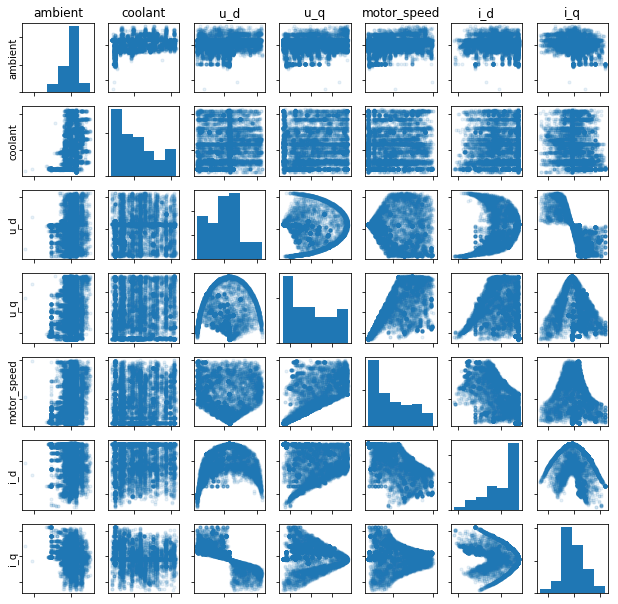

In [82]:
p_in = len(x_att)
p_out = len(y_att)
k = 0
plt.figure(figsize=(1.5*p_in,1.5*p_in))
plt.clf
n_plot = np.random.choice(np.arange(n_train),10000)
for i in np.arange(0,p_in):
    for j in np.arange(0,p_in):
        k = k+1
        plt.subplot(p_in,p_in,k)
        if i==j:
            plt.hist(X_train[n_plot,i],6)
            plt.axis('tight')
        else:
            plt.plot(X_train[n_plot,j],X_train[n_plot,i], '.',alpha=0.1)
        plt.axis('tight')
        
        if i==0:
            plt.title(Xlabels[x_att[j]])
        if j==0:
            plt.ylabel(Xlabels[x_att[i]])
        plt.tick_params(axis='x', labelbottom=False)
        plt.tick_params(axis='y', labelleft=False)
        


Cela est encore plus flagrant pour les **attributs cibles**, notamment les températures des différentes parties du *stator*, qui semblent alignées entre elles. La température du *rotor* est un peu moins corrélées à celle du *stator*.

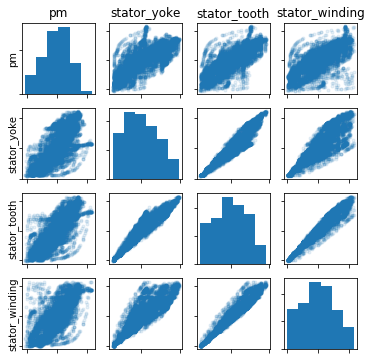

In [83]:
k = 0
plt.figure(figsize=(1.5*p_out,1.5*p_out))
plt.clf
n_plot = np.random.choice(np.arange(n_train),10000)
for i in np.arange(0,p_out):
    for j in np.arange(0,p_out):
        k = k+1
        plt.subplot(p_out,p_out,k)
        if i==j:
            plt.hist(Y_train[n_plot,i],6)
            plt.axis('tight')
        else:
            plt.plot(Y_train[n_plot,j],Y_train[n_plot,i], '.',alpha=0.1)
        plt.axis('tight')
        
        if i==0:
            plt.title(Xlabels[y_att[j]])
            
        if j==0:
            plt.ylabel(Xlabels[y_att[i]])
        plt.tick_params(axis='x', labelbottom=False)
        plt.tick_params(axis='y', labelleft=False)
        

Enfin, si on affiche le lien entre **les attributs d'entrée** et **les attributs cibles**, on constate peu de corrélation directe entre les deux, mis à part pour le *liquide de refroidissement* qui est légèrement corrélé aux attributs cibles.

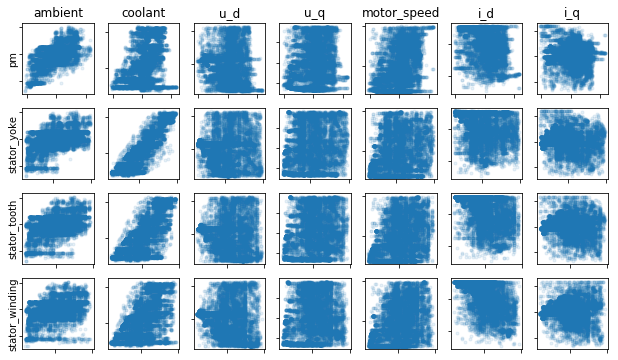

In [84]:
k = 0
plt.figure(figsize=(1.5*p_in,1.5*p_out))
plt.clf
n_plot = np.random.choice(np.arange(n_train),10000)
for i in np.arange(0,p_out):
    for j in np.arange(0,p_in):
        k = k+1
        plt.subplot(p_out,p_in,k)
        plt.plot(Y_train[n_plot,i],X_train[n_plot,j], '.',alpha=0.1)
        plt.axis('tight')
        
        if i==0:
            plt.title(Xlabels[x_att[j]])
            
        if j==0:
            plt.ylabel(Xlabels[y_att[i]])
        plt.tick_params(axis='x', labelbottom=False)
        plt.tick_params(axis='y', labelleft=False)
        

Si on affiche par exemple **le contenu d'une session**, on obtient les figures ci-dessous. Il est intéressant de constater que les trois mesures de températures sur le *stator* sont fortement corrélées. On constate également quelques relations de type $U = RI$ au niveau des **voltages et intensités**.

Session :  29.0


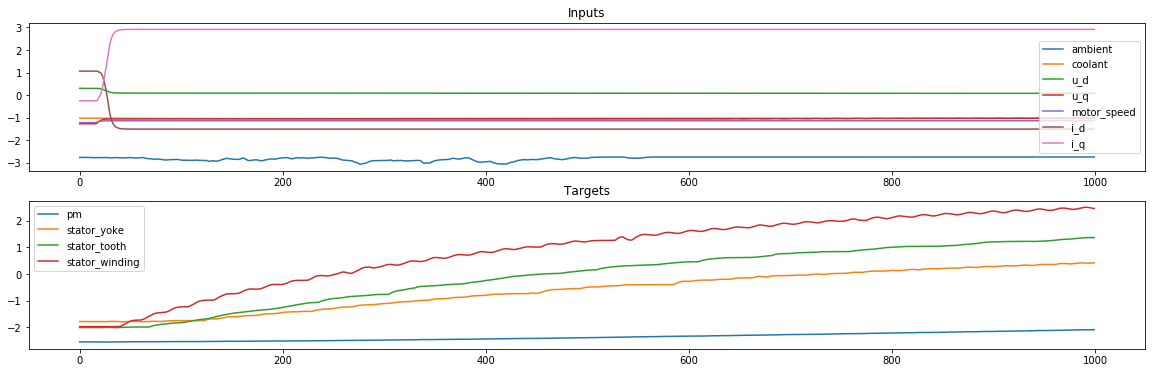

In [85]:
sess = np.random.choice(sess_id,1)
data_sess = get_session(X,sess)
X_sess = data_sess[:,x_att]
Y_sess = data_sess[:,y_att]
plt.figure(figsize=(20,6))
plt.clf

print("Session : ",sess[0])
plt.subplot(2,1,1)
for i in range(len(x_att)):
    plt.plot(X_sess[:1000,i])
plt.title("Inputs")
plt.legend(Xlabels[x_att]);
plt.subplot(2,1,2)
for i in range(len(y_att)):
    plt.plot(Y_sess[:1000,i])
plt.title("Targets")
plt.legend(Xlabels[y_att]);

# II. Modèles simples
## II.A. Regression linéaire classique

La première méthode est de résoudre le problème d'optimisation
\begin{align}
w^* = argmin_w \frac{1}{n}\sum_{i=1}^{n}|| X_iw - Y_i ||_2^2 = argmin_w F_{X,Y}(w)
\end{align}

En supposant $X^TX$ inversible, la fonction $F_{X,Y}$ est strictement convexe en $w$ comme somme de fonction convexe, elle admet donc un unique minimiseur $w^*$. En utilisant le fait que $\nabla F_{X,Y}(w^*) = 0$ et on obtient la forme close :

\begin{align}
w^* = (X^TX)^{-1}X^TY
\end{align}

In [86]:
w = np.linalg.solve(X_train.transpose().dot(X_train), X_train.transpose().dot(Y_train) )

Ci-dessous, on peut voir que les courbes obtenues pour les attributs cibles sont assez éloignés de la réalité. Une des principales erreurs semblent être que notre modèle, ne prenant pas en compte le temps, subit des sauts brusques de température **au lieu d'une évolution progressive** comme dans la réalité.

SESSION  6


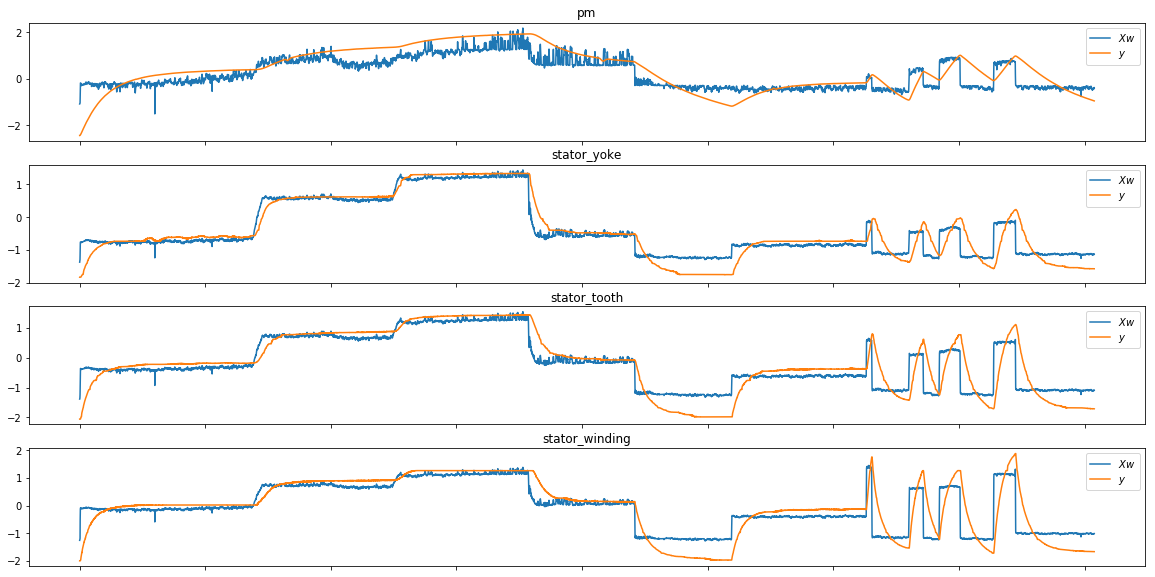

In [87]:
sess_test = np.random.choice(Itest,1)
data_sess = get_session(X,sess_test)
X_test_sess = data_sess[:,x_att]
X_test_sess = np.concatenate([X_test_sess,np.ones((len(X_test_sess),1))],axis=1)
Y_test_sess = data_sess[:,y_att]
plt.clf
plt.figure(figsize=(20,10))
print("SESSION ",int(sess_test[0]))
for i in range(p_out):
    plt.subplot(p_out,1,i+1)
    plt.plot( X_test_sess.dot(w)[:,i], '-' )
    plt.plot( Y_test_sess[:,i], '-' )
    plt.title(Xlabels[y_att[i]])
    plt.axis('tight')
    plt.tick_params(axis='x', labelbottom=False)
    plt.legend(['$X w$','$y$']);

L'**erreur de test** (MSE) est d'ailleurs plutôt elevée : $ 0.358$.

In [88]:
def print_error(w):
    E = (np.square(X_train.dot(w)-Y_train)).mean()
    print(( 'Relative prediction error (train): ' + str(E) ) );
    E = (np.square(X_test.dot(w)-Y_test)).mean()
    print(( 'Relative prediction error (test): ' + str(E) ) );

    ##Erreur de chaque sortie :
    for i in range(p_out):
        print()
        print("Sortie : ",Xlabels[y_att[i]])
        E = (np.square(X_train.dot(w)[:,i]-Y_train[:,i])).mean()
        print(( 'Relative prediction error (train): ' + str(E) ) );
        E = (np.square(X_test.dot(w)[:,i]-Y_test[:,i])).mean()
        print(( 'Relative prediction error (test): ' + str(E) ) );

print_error(w)

Relative prediction error (train): 0.32865054516436687
Relative prediction error (test): 0.35774291940407016

Sortie :  pm
Relative prediction error (train): 0.498246013234601
Relative prediction error (test): 0.5930497827881659

Sortie :  stator_yoke
Relative prediction error (train): 0.15424165129440626
Relative prediction error (test): 0.15419597994999978

Sortie :  stator_tooth
Relative prediction error (train): 0.29474805502612833
Relative prediction error (test): 0.3051877730352546

Sortie :  stator_winding
Relative prediction error (train): 0.36736646110233134
Relative prediction error (test): 0.3785381418428612


## II.B. Regularisation Ridge

La régularisation *Ridge* consiste à régulariser le carré de la norme 2 des poids du modèle (ici $w$). On a donc
\begin{align}
w^* = argmin_w \frac{1}{n}\sum_{i=1}^{n}|| X_iw - Y_i ||_2^2 + \lambda||w||^2_2
\end{align}

Ici aussi, la fonction est strictement convexe en $w$ comme somme de fonction strictement convexe. On a donc un minimiseur lorsque la fonction s'annule, c'est-à-dire en 
\begin{align}
w^* = (X^TX + \lambda I)^{-1}X^TY
\end{align}

On essaie pour plusieurs valeurs de $\lambda$ afin de trouver la valeur qui minimise l'erreur.

 Lambda :  21777.915108595087
Relative prediction error (train): 0.3313989014305418
Relative prediction error (test): 0.35577046907403187

Sortie :  pm
Relative prediction error (train): 0.5009878940285158
Relative prediction error (test): 0.593257678231957

Sortie :  stator_yoke
Relative prediction error (train): 0.15607112197847717
Relative prediction error (test): 0.15295048496061997

Sortie :  stator_tooth
Relative prediction error (train): 0.2970273200203319
Relative prediction error (test): 0.30250101787256917

Sortie :  stator_winding
Relative prediction error (train): 0.3715092696948433
Relative prediction error (test): 0.3743726952309817


Text(0, 0.5, '$E$')

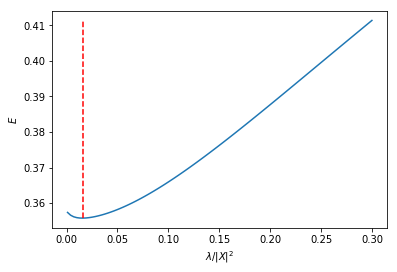

In [89]:
q = 100
lmax = np.linalg.norm(X_train,2)**(2)
lambda_list = lmax*np.linspace(.3,1e-3,q)
W = np.zeros( (p_in+1,p_out,q) )
E = np.zeros( (q,1) )
for i in np.arange(0,q):
    Lambda = lambda_list[i]
    w = np.linalg.solve( X_train.transpose().dot(X_train) + Lambda*np.eye(p_in+1), X_train.transpose().dot(Y_train) )
    W[:,:,i] = w
    E[i] = (np.square(X_test.dot(w)-Y_test)).mean()
# find optimal lambda
i = E.argmin()
lambda0 = lambda_list[i]
wRidge = W[:,:,i]
print(' Lambda : ',lambda0)
print_error(wRidge)
# Display error evolution.
plt.clf
plt.plot(lambda_list/lmax, E)
plt.plot( [lambda0/lmax,lambda0/lmax], [E.min(), E.max()], 'r--')
plt.axis('tight')
plt.xlabel('$\lambda/|X|^2$')
plt.ylabel('$E$')

On voit ci-dessus que le progrès est **minime**, on passe de $0.358$ d'erreur MSE à $0.356$. 

Les graphique suivants nous permettent de constater que les coefficients de $w$ diminue avec le facteur de régularisation $\lambda$, ce qui est attendu.

Text(0, 0.5, '$E$')

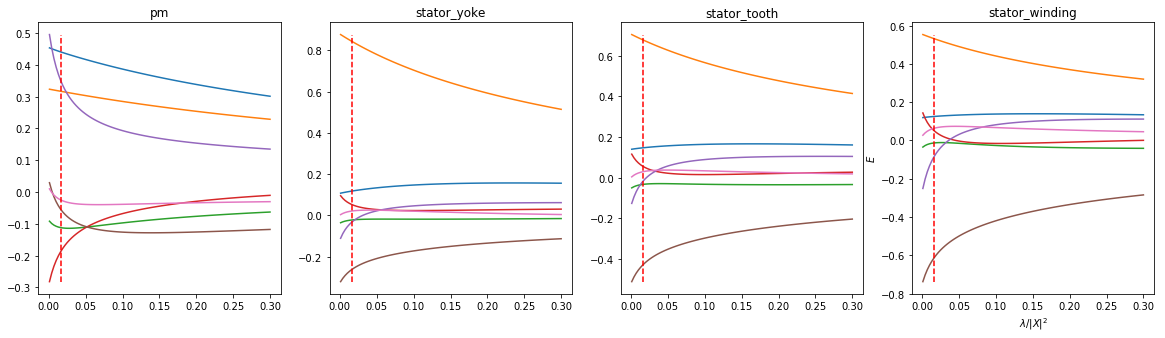

In [90]:
plt.clf
plt.clf
plt.figure(figsize=(p_out*5,5))
for i in range(p_out):
    plt.subplot(1,p_out,i+1)
    for j in range(p_in):
        plt.plot(lambda_list/lmax, W[j,i])
    plt.plot( [lambda0/lmax,lambda0/lmax], [W[:,i].min(), W[:,i].max()], 'r--')
    plt.title(Xlabels[y_att[i]])
plt.axis('tight')
plt.xlabel('$\lambda/|X|^2$')
plt.ylabel('$E$')

## II.C. Régularisation Lasso

Une deuxième méthode de régularisation qui est très répendue est le régularisation par la norme 1, appellée *Lasso*. L'idée derrière cette méthode est qu'en normalisant par la norme 1, on a plus de chance d'obtenir des poids nuls, et donc d'obtenir un modèle plus simple (limitant ainsi le risque d'*overfit*).

On cherche donc
\begin{align}
w^* = argmin_w \frac{1}{n}\sum_{i = 1}^{n} ||X_iw-Y_i||^2_2 + \lambda ||w||_1 = argmin_w F_{X,Y}(w)
\end{align}

Pour calculer $w^*$ nous allons utiliser la méthode de **descente de gradient** car la fonction n'est pas dérivable.

L'algorithme de descente de gradient est le suivant :

1. Initialiser $w$ avec des poids aléatoires, ou bien égal au vecteur nul.
2. A chaque étape, mettre à jour $w$ en fonction du gradient de F en $w$:
\begin{align}
w \leftarrow w - \tau \nabla F_{X,Y}(w)
\end{align}
    avec $\tau$ le pas de la descente de gradient.
    
On utilise ici l'algorithme **ISTA** pour notre descentre de gradient (voir ci dessous).
    

In [91]:
def J(w,Lambda): return 1/2*np.linalg.norm(X_train.dot(w)-Y_train)**2 + Lambda*np.linalg.norm(w,1)

def Soft(x,s): return np.maximum( abs(x)-s, np.zeros(x.shape)  ) * np.sign(x)

C = X_train.transpose().dot(X_train)
u = X_train.transpose().dot(Y_train)

def ISTA(w,Lambda,tau): return Soft( w-tau*( C.dot(w)-u ), Lambda*tau )

tau = 1.5/np.linalg.norm(X_train,2)**2
lmax = abs( X_train.transpose().dot(Y_train) ).max()
Lambda = lmax /100

On voit que la fonction de l'énergie $J$ diminue bien au fil de la descente de gradient.

Text(0.5, 1.0, 'J(w_k)')

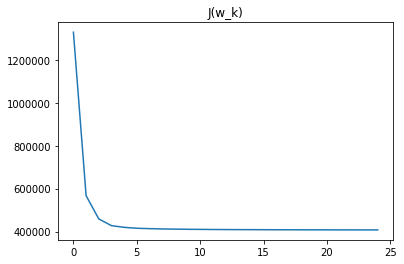

In [92]:
niter = 100
Jlist = np.zeros((niter,1))
w = np.zeros((p_in+1,p_out))

for i in np.arange(0,niter):
    Jlist[i] = J(w,Lambda)
    w = ISTA(w,Lambda,tau)
ndisp = int(niter/4)

plt.clf
plt.plot(Jlist[0:ndisp])
plt.axis('tight')
plt.title('J(w_k)')

Relative prediction error (train): 0.3310805290716516
Relative prediction error (test): 0.3552882717799405

Sortie :  pm
Relative prediction error (train): 0.49952421598759245
Relative prediction error (test): 0.595224176535613

Sortie :  stator_yoke
Relative prediction error (train): 0.15590862845157283
Relative prediction error (test): 0.15183427948769262

Sortie :  stator_tooth
Relative prediction error (train): 0.2969261011907041
Relative prediction error (test): 0.30103995730002386

Sortie :  stator_winding
Relative prediction error (train): 0.3719631706567373
Relative prediction error (test): 0.37305467379643215


Text(0, 0.5, '$E$')

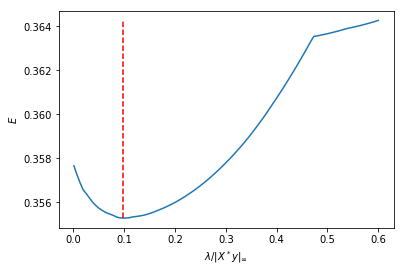

In [93]:
q = 100
lmax = abs( X_train.transpose().dot(Y_train) ).max()/10
lambda_list = lmax*np.linspace(.6,1e-3,q)
W = np.zeros( (p_in+1,p_out,q) )
E = np.zeros( (q,1) )
w = np.zeros((p_in+1,p_out))
niter = 100
for iq in np.arange(0,q):
    Lambda = lambda_list[iq]
    # ISTA #
    for i in np.arange(0,niter):
        w = ISTA(w,Lambda,tau)
    W[:,:,iq] = w
    E[iq] = (np.square(X_test.dot(w)-Y_test)).mean()
# find optimal Lambda
i = E.argmin()
lambda0 = lambda_list[i]
wSparse = W[:,:,i]
print_error(wSparse)
# Display error evolution.
plt.clf
plt.plot(lambda_list/lmax, E)
plt.plot( [lambda0/lmax,lambda0/lmax], [E.min(),E.max()], 'r--')
plt.axis('tight')
plt.xlabel('$\lambda/|X^* y|_\infty$')
plt.ylabel('$E$')

On obtient cette fois une MSE d'environ $0.355$ pour le $\lambda$ optimal.

Sur les graphique suivants, on constat qu'avec la méthode ***lasso***, les poids sont plus facilement mis à $0$ par notre algorithme.

Text(0, 0.5, '$E$')

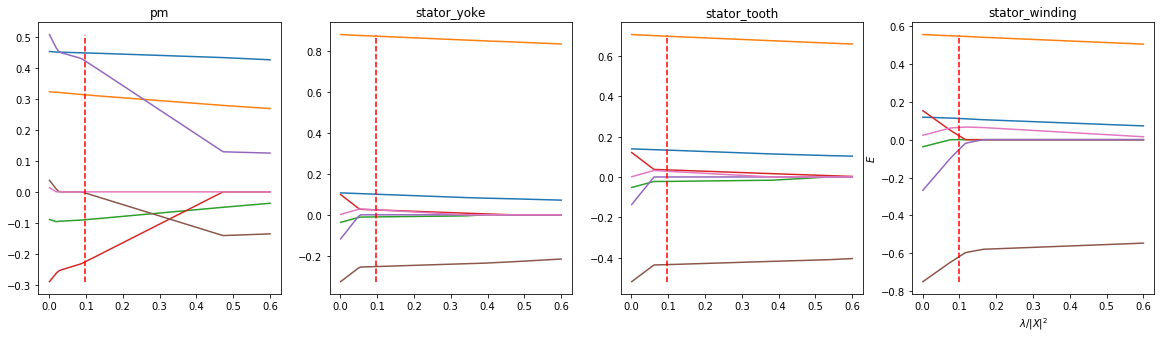

In [94]:
plt.clf
plt.figure(figsize=(p_out*5,5))
for i in range(p_out):
    plt.subplot(1,p_out,i+1)
    for j in range(p_in):
        plt.plot(lambda_list/lmax, W[j,i])
    plt.plot( [lambda0/lmax,lambda0/lmax], [W[:,i].min(), W[:,i].max()], 'r--')
    plt.title(Xlabels[y_att[i]])
plt.axis('tight')
plt.xlabel('$\lambda/|X|^2$')
plt.ylabel('$E$')

Enfin, le graphique suivant montre le poids associé à chaque attribut. Ils sont assez similaires pour ***Ridge*** et ***Lasso*** mais les poids du *Lasso* sont plus souvent nuls.

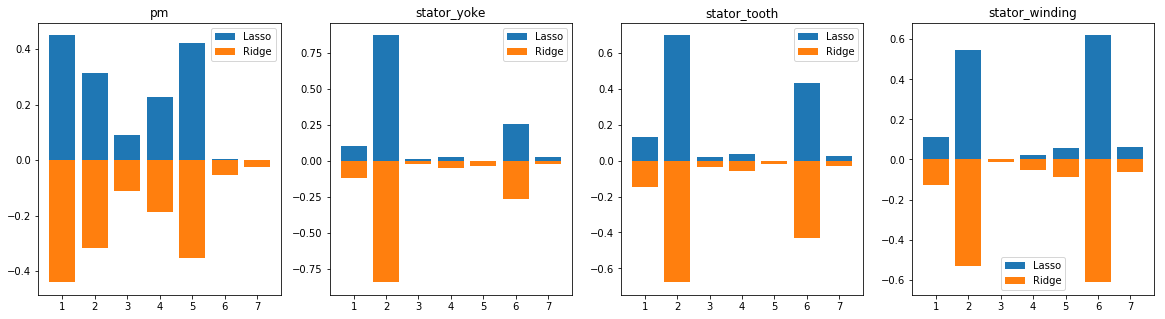

In [95]:

plt.clf
plt.figure(figsize=(p_out*5,5))
for i in range(p_out):
    plt.subplot(1,p_out,i+1)
    plt.bar(np.arange(1,p_in+1), abs(wSparse[:-1,i]))
    plt.bar(np.arange(1,p_in+1), -abs(wRidge[:-1,i]))
    plt.title(Xlabels[y_att[i]])
    plt.legend(('Lasso', 'Ridge'))
    

# III. Utiliser la prédiction précédente


## III.A. Initialisation naïve.

Comme précisée au début de ce notebook, les données sont divisées en **52 sessions** de conduites de quelques heures, et donc les enregistrements se succèdent de quelques millisecondes au sein d'une session. Il serait donc intéressant de prendre en compte la prédiction au temps $t-1$ pour effectuer une prédiction au temps $t$. Dans le cas de la transformation linéaire, on aurait une formule de la sorte :


\begin{align}
Y_{t+1} = \alpha w_y Y_t + (1-\alpha)w_xX_{t+1}
\end{align}


avec $\alpha \in [0,1]$. Si on ajoute $Y_{t-1}$ à la fin de chaque vecteur $X_{t}$, on a donc $Y_{t} = \hat{w}X_{t}$.

Pour les données d'entrainement, on peut donc entrainer à partir des valeurs cible au temps $t-1$, et pour tester, on utilise la prédiction au temps précédent. Enfin, pour la première prédiction, on utilise pour le moment $Y_{-1} = 0$.

In [96]:
p_out = 4
p_in = 7
X_bis = np.zeros((n,p_tot+p_out))
current_session = -1
offset = 1
offset_in = 0
new_session = []
for i in range(len(X)):
    X_bis[i,p_out:] = X[i]
    if X[i,-1] != current_session:
        new_session.append(X[i])
        current_session = X[i,-1]
        X_bis[i,:p_out] = np.zeros(p_out)
        offset_in = 0
    else:
        if offset_in < offset:
            X_bis[i,:p_out] = np.zeros(p_out)
            offset_in += 1
        else:
            X_bis[i,:p_out] = X[i-1,8:12]

#On récupère les données de test et de train
data_train = get_session(X_bis,Itrain)
data_test = get_session(X,Itest)

# On mélange les données d'entrainement
np.random.shuffle(data_train)

x_att_bis = np.array([0,1,2,3,4,5,6,7,8,10,11])
y_att_bis = np.array([12,13,14,15])
X_train = data_train[:,x_att_bis]
X_test = data_test[:,x_att]
#X_train = np.concatenate([np.ones((len(X_train),1)),X_train],axis=1)
#X_test = np.concatenate([np.ones((len(X_test),1)),X_test],axis=1)
Y_train = data_train[:,y_att_bis]
Y_test = data_test[:,y_att]
new_session = np.array(new_session)

On utilise la méthode classique de minimisation de la norme 2, sans régularisation, et on constate sur les graphiques ci-dessous que **les résultats collent beaucoup plus à la réalité que précédemment**.

SESSION  76


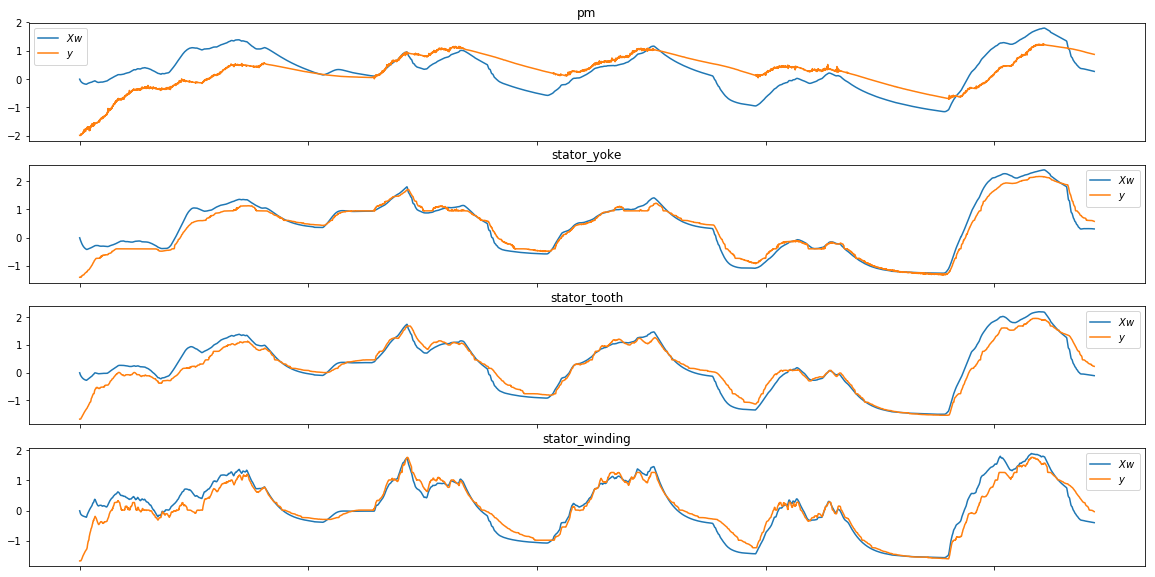

In [97]:
w = np.linalg.solve(X_train.transpose().dot(X_train), X_train.transpose().dot(Y_train) )

sess_test = np.random.choice(Itest,1)
data_sess = get_session(X,sess_test)
X_test_sess = data_sess[:,x_att]
#X_test_sess = np.concatenate([np.ones((len(X_test_sess),1)),X_test_sess],axis=1)
Y_test_sess = data_sess[:,y_att]
plt.clf
plt.figure(figsize=(20,10))
print("SESSION ",int(sess_test[0]))
Y_pred = [np.zeros(4)]*offset
for i in range(len(X_test_sess)):
    X_in = np.concatenate([Y_pred[-offset],X_test_sess[i]])
    Y_pred.append(X_in.dot(w))

Y_pred = np.array(Y_pred)

for i in range(p_out):
    plt.subplot(p_out,1,i+1)
    plt.plot(Y_pred[offset:,i], '-' )
    plt.plot( Y_test_sess[:,i], '-' )
    plt.title(Xlabels[y_att[i]])
    plt.axis('tight')
    plt.tick_params(axis='x', labelbottom=False)
    plt.legend(['$X w$','$y$']);
    

En observant le poids de chaque entrée, on constate que la somme **des poids des prédictions au temps $t-1$** tourne autour des $99\%$ (première rangée). Cependant, les poids qui auront le rôle le plus important sont ceux **des autres entrées**, car ce sont eux qui vont déterminer si la température va *augmenter* ou *décroitre* (deuxième rangée).

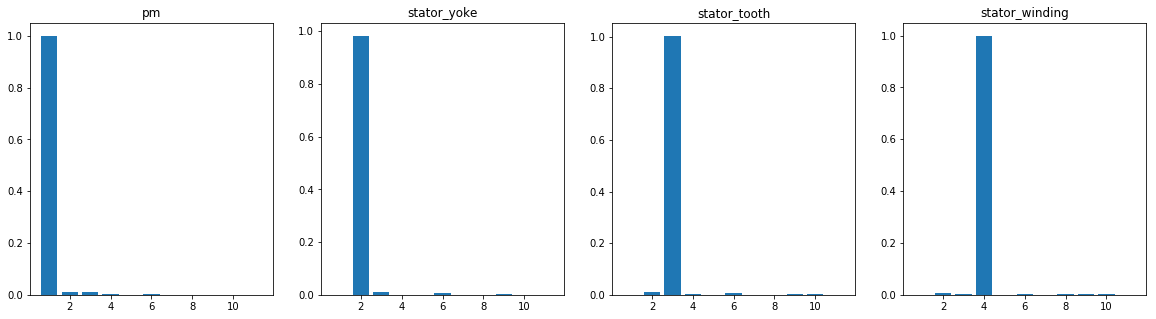

In [98]:

plt.clf
plt.figure(figsize=(p_out*5,5))
for i in range(p_out):
    plt.subplot(1,p_out,i+1)
    plt.bar(np.arange(1,p_in+1+4), abs(w[:,i]))
    plt.title(Xlabels[y_att[i]])

Dans cette deuxième rangée, on affiche uniquement les poids des entrées qui ne sont **pas les prédictions** du temps $t-1$.

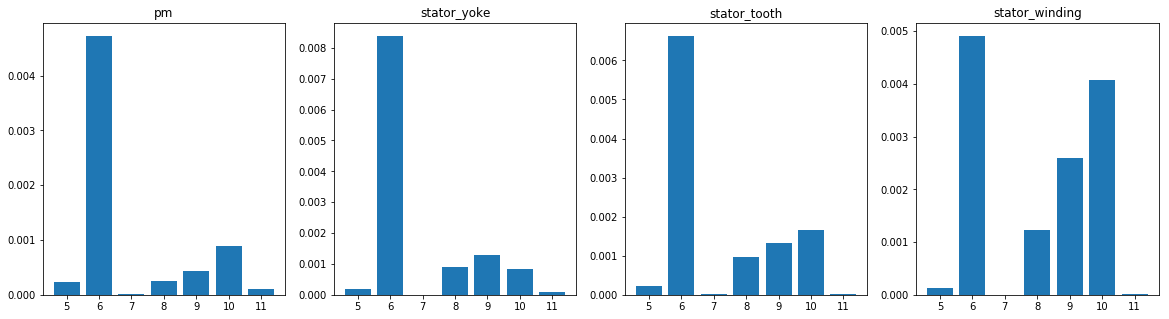

In [99]:

plt.clf
plt.figure(figsize=(p_out*5,5))
for i in range(p_out):
    plt.subplot(1,p_out,i+1)
    plt.bar(np.arange(5,p_in+1+4), abs(w[4:,i]))
    plt.title(Xlabels[y_att[i]])
    

Enfin, ci dessous je calcule l'erreur moyenne sur les données de test, on passe d'une MSE de **0.35** à **0.15**.

In [100]:
def print_error_time(w,w_SS=np.zeros((2,4))):
    print("Running on Test Data...")
    Yptest = []
    for sess_test in Itest:
        data_sess = get_session(X,int(sess_test))
        X_test_sess = data_sess[:,x_att]
        Y_test_sess = data_sess[:,y_att]
        #print("SESSION ",int(sess_test))
        Y_pred = [np.array([X_test_sess[0,1],1]).dot(w_SS)]
        for i in range(len(X_test_sess)):
            X_in = np.concatenate([Y_pred[-offset],X_test_sess[i]])
            Y_pred.append(X_in.dot(w))

        Y_pred = Y_pred[offset:]
        Yptest.extend(Y_pred)
    Yptest = np.array(Yptest)
    E = (np.square(Yptest-Y_test)).mean()
    print(( 'Relative prediction error (test): ' + str(E) ) );

    ##Erreur de chaque sortie :
    for i in range(p_out):
        print()
        print("Sortie : ",Xlabels[y_att[i]])
        E = (np.square(Yptest[:,i]-Y_test[:,i])).mean()
        print(( 'Relative prediction error (test): ' + str(E) ) );
        
def Rel_Error(w,w_SS=np.zeros((2,4))):
    #print("Running on Test Data...")
    Yptest = []
    for sess_test in Itest:
        data_sess = get_session(X,int(sess_test))
        X_test_sess = data_sess[:,x_att]
        Y_test_sess = data_sess[:,y_att]
        #print("SESSION ",int(sess_test))
        Y_pred = [np.array([X_test_sess[0,1],1]).dot(w_SS)]
        for i in range(len(X_test_sess)):
            X_in = np.concatenate([Y_pred[-offset],X_test_sess[i]])
            Y_pred.append(X_in.dot(w))

        Y_pred = Y_pred[offset:]
        Yptest.extend(Y_pred)
    Yptest = np.array(Yptest)
    E = (np.square(Yptest-Y_test)).mean()
    return E


print_error_time(w)

Running on Test Data...
Relative prediction error (test): 0.1531307766399849

Sortie :  pm
Relative prediction error (test): 0.38299262969857417

Sortie :  stator_yoke
Relative prediction error (test): 0.04669365940728023

Sortie :  stator_tooth
Relative prediction error (test): 0.08649399835908915

Sortie :  stator_winding
Relative prediction error (test): 0.0963428190949961


## III.B. Améliorer la prédiction initiale.

Cependant, on constate que la prédiction du temps précédent utilisé au début de chaque session est plutôt éloignée de la réalité. On pourrait penser qu'en début de session, la température des matériaux est fortement liée à la **température ambiante** ou à celle du **liquide de refroidissement**. Dans le code ci-dessous, on observe le lien entre les données d'entrée et de sortie pour le *session_starter*, c'est-à-dire le premier enregistrement de chaque session.

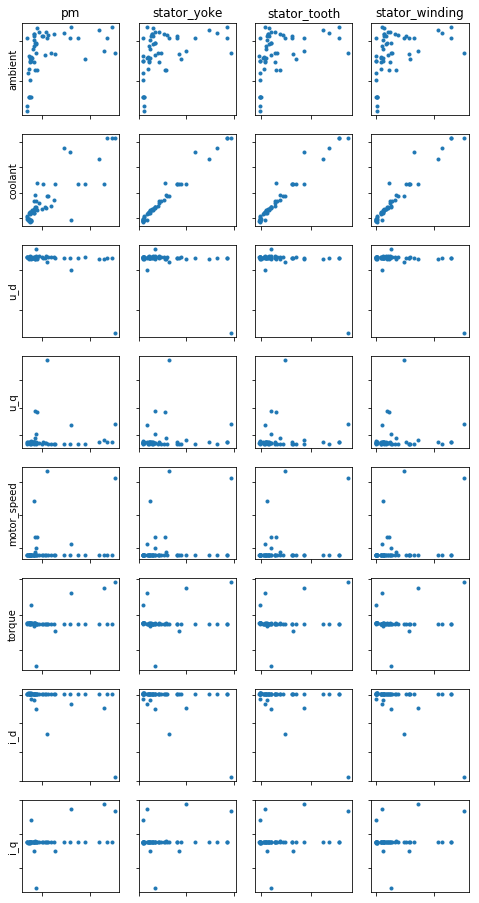

In [101]:
k = 0
plt.figure(figsize=(4*2,8*2))
x_in = np.arange(8)
x_out = np.arange(8,12)
plt.clf
for i in np.arange(0,len(x_in)):
    for j in np.arange(0,len(x_out)):
        k = k+1
        plt.subplot(len(x_in),len(x_out),k)
        plt.plot(new_session[:,x_out[j]],new_session[:,x_in[i]], '.',alpha=1)
        plt.axis('tight')
        if i==0:
            plt.title(Xlabels[x_out[j]])
            
        if j==0:
            plt.ylabel(Xlabels[x_in[i]])
        
        plt.tick_params(axis='x', labelbottom=False)
        plt.tick_params(axis='y', labelleft=False)

On constate en effet une forte corrélation avec la température du liquide de refroidissement (*coolant*) et une légère corrélation avec la température extérieure (*ambiant*). On pourrait résoudre faire un modèle linéaire en utilisant toutes les entrées, mais nous allons nous contenter d'un **modèle simple** utilisant uniquement l'entrée *coolant*. Nous allons pour cela chercher la transformation affine pour passer de la température coolant aux températures de stator/motor.

In [102]:
def get_session_starter(X,ids):
    session_starter_ind = [1,8,9,10,11]
    current_session = -1
    new_session = []
    if type(ids) == int:
        ids = [ids]
    for i in range(len(X)):
        X_bis[i,p_out:] = X[i]
        if X[i,-1] != current_session:
            if X[i,-1] in ids:
                new_session.append(X[i][session_starter_ind])
            current_session = X[i,-1]
    return np.array(new_session)

SS_train = get_session_starter(X,Itrain)
SS_test = get_session_starter(X,Itest)

On ajoute une colonne de **1** pour prendre en compte le biais.

In [103]:
X_SS_train = SS_train[:,:2].copy()
X_SS_test = SS_test[:,:2].copy()
X_SS_train[:,1] = np.ones(len(X_SS_train))
X_SS_test[:,1] = np.ones(len(X_SS_test))
Y_SS_train = SS_train[:,1:].copy()
Y_SS_test = SS_test[:,1:].copy()

On résout le problème d'optimisation sur les sessions d'entrainements avec la formule 
\begin{align}
    w_{ss} = (X_{ss}^TX_{ss})X_{ss}Y_{ss}
\end{align}

In [104]:
w_SS = np.linalg.solve(X_SS_train.transpose().dot(X_SS_train), X_SS_train.transpose().dot(Y_SS_train))

Avec cette simple transformation linéaire, la **MSE** est raisonnable (autour de **0.14**)

In [105]:
Etrain = (np.square(X_SS_train.dot(w_SS)-Y_SS_train)).mean()
Etest = (np.square(X_SS_test.dot(w_SS)-Y_SS_test)).mean()
print("MSE (train) : ",Etrain)
print("MSE (test) : ",Etest)

MSE (train) :  0.0636595147134851
MSE (test) :  0.1351178798572363


On peut observer ci-dessous que **la fonction affine** liée à **w** (en rouge) colle très bien aux données des *sessions starters* (en bleu).

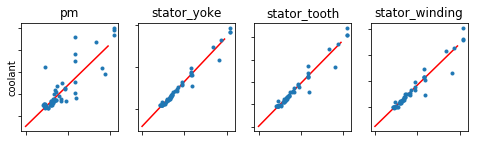

In [106]:
k = 0
plt.figure(figsize=(4*2,1*2))
x_out = np.arange(8,12)
plt.clf
for j in np.arange(0,len(x_out)):
    k = k+1
    plt.subplot(1,len(x_out),k)
    pts = np.arange(-2,2,0.1)
    pts_l = len(pts)
    pts_x = np.ones((pts_l,2))
    pts_x[:,0] = pts
    y_pred = pts_x.dot(w_SS)
    plt.plot(pts,y_pred[:,j],'-',color='red')
    plt.plot(new_session[:,1],new_session[:,x_out[j]], '.',alpha=1)
    plt.axis('tight')
    plt.title(Xlabels[x_out[j]])
    if j==0:
        plt.ylabel(Xlabels[1])
        
    plt.tick_params(axis='x', labelbottom=False)
    plt.tick_params(axis='y', labelleft=False)

On va maintenant utiliser $w_{ss}$ afin de prédire avec plus de précision les premières valeurs de sortie. On génère d'abord les données d'entraînement (la seule modification est sur le premier vecteur de chaque section).

In [107]:
p_out = 4
p_in = 7
X_bis = np.zeros((n,p_tot+p_out))
current_session = -1
offset = 1
offset_in = 0
new_session = []
for i in range(len(X)):
    X_bis[i,p_out:] = X[i]
    if X[i,-1] != current_session:
        new_session.append(X[i])
        current_session = X[i,-1]
        X_bis[i,:p_out] = np.array([X[i,1],1]).dot(w_SS)
        offset_in = 0
    else:
        if offset_in < offset:
            X_bis[i,:p_out] = np.array([X[i,1],1]).dot(w_SS)
            offset_in += 1
        else:
            X_bis[i,:p_out] = X[i-1,8:12]

#On récupère les données de test et de train
data_train = get_session(X_bis,Itrain)
data_test = get_session(X,Itest)

# On mélange les données d'entrainement
np.random.shuffle(data_train)

x_att_bis = np.array([0,1,2,3,4,5,6,7,8,10,11])
y_att_bis = np.array([12,13,14,15])
X_train = data_train[:,x_att_bis]
X_test = data_test[:,x_att]
#X_train = np.concatenate([np.ones((len(X_train),1)),X_train],axis=1)
#X_test = np.concatenate([np.ones((len(X_test),1)),X_test],axis=1)
Y_train = data_train[:,y_att_bis]
Y_test = data_test[:,y_att]
new_session = np.array(new_session)

Le graphique ci-dessous représente l'évolution des attributs de sortie et les prédictions. On peut voir que la prédiction est beaucoup plus précise qu'auparavant, notamment la prédiction **au temps t = 0** (*session starter*).

SESSION  29


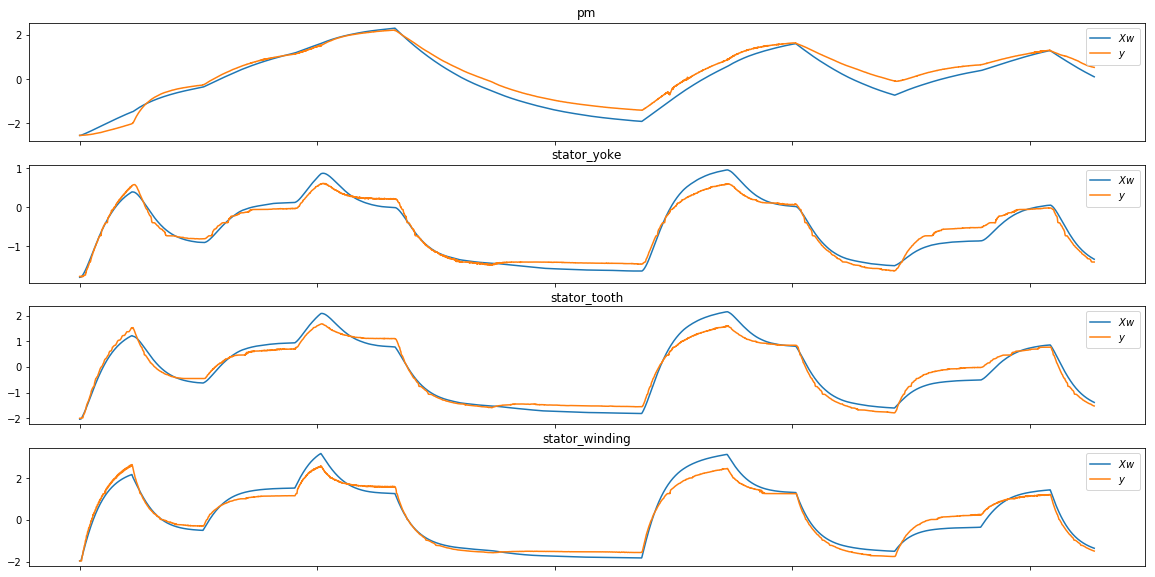

In [108]:
w = np.linalg.solve(X_train.transpose().dot(X_train), X_train.transpose().dot(Y_train) )

sess_test = np.random.choice(Itest,1)
data_sess = get_session(X,sess_test)
X_test_sess = data_sess[:,x_att]
Y_test_sess = data_sess[:,y_att]
plt.clf
plt.figure(figsize=(20,10))
print("SESSION ",int(sess_test[0]))
Y_pred = [np.array([X_test_sess[0,1],1]).dot(w_SS)]
for i in range(len(X_test_sess)):
    X_in = np.concatenate([Y_pred[-offset],X_test_sess[i]])
    Y_pred.append(X_in.dot(w))

Y_pred = np.array(Y_pred)

for i in range(p_out):
    plt.subplot(p_out,1,i+1)
    plt.plot(Y_pred[offset:,i], '-' )
    plt.plot( Y_test_sess[:,i], '-' )
    plt.title(Xlabels[y_att[i]])
    plt.axis('tight')
    plt.tick_params(axis='x', labelbottom=False)
    plt.legend(['$X w$','$y$']);
    

On le voit d'ailleurs en observant l'**erreur relative diminue encore**, tombant cette fois à **0.058**.

In [109]:
print_error_time(w,w_SS)

Running on Test Data...
Relative prediction error (test): 0.05841267194027385

Sortie :  pm
Relative prediction error (test): 0.1152953192747371

Sortie :  stator_yoke
Relative prediction error (test): 0.019334527279637637

Sortie :  stator_tooth
Relative prediction error (test): 0.04228737967989959

Sortie :  stator_winding
Relative prediction error (test): 0.05673346152682122


On teste avec la régularisation ***Ridge*** et on constate un minimum à **0.052** de RMSE.

Testing  106.44511818909675  ( 1 / 10 )
Testing  94.65730695260048  ( 2 / 10 )
Testing  82.8694957161042  ( 3 / 10 )
Testing  71.08168447960793  ( 4 / 10 )
Testing  59.29387324311166  ( 5 / 10 )
Testing  47.5060620066154  ( 6 / 10 )
Testing  35.71825077011913  ( 7 / 10 )
Testing  23.930439533622852  ( 8 / 10 )
Testing  12.142628297126587  ( 9 / 10 )
Testing  0.3548170606303225  ( 10 / 10 )
 Lambda :  59.29387324311166


Text(0, 0.5, '$E$')

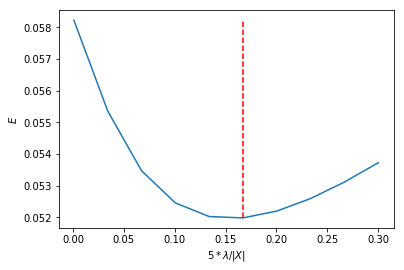

In [110]:
q = 10
lmax = np.linalg.norm(X_train,2)/5
lambda_list = lmax*np.linspace(.3,1e-3,q)
W = np.zeros( (p_in+4,p_out,q) )
E = np.zeros( (q,1) )
for i in np.arange(0,q):
    print("Testing ",lambda_list[i]," (",i+1,"/",q,")")
    Lambda = lambda_list[i]
    w = np.linalg.solve( X_train.transpose().dot(X_train) + Lambda*np.eye(len(X_train[0])), X_train.transpose().dot(Y_train) )
    W[:,:,i] = w
    E[i] = Rel_Error(w,w_SS)
# find optimal lambda
i = E.argmin()
lambda0 = lambda_list[i]
wRidge = W[:,:,i]
print(' Lambda : ',lambda0)
# Display error evolution.
plt.clf
plt.plot(lambda_list/lmax, E)
plt.plot( [lambda0/lmax,lambda0/lmax], [E.min(), E.max()], 'r--')
plt.axis('tight')
plt.xlabel('$5*\lambda/|X|$')
plt.ylabel('$E$')

Avec la régularisation ***Lasso***, la RMSE ne descend pas en dessous de **0.06**

Testing  0.6  ( 1 / 10 )
Testing  0.5334444444444444  ( 2 / 10 )
Testing  0.4668888888888889  ( 3 / 10 )
Testing  0.4003333333333333  ( 4 / 10 )
Testing  0.3337777777777778  ( 5 / 10 )
Testing  0.26722222222222225  ( 6 / 10 )
Testing  0.20066666666666666  ( 7 / 10 )
Testing  0.13411111111111113  ( 8 / 10 )
Testing  0.06755555555555559  ( 9 / 10 )
Testing  0.001  ( 10 / 10 )


Text(0, 0.5, '$E$')

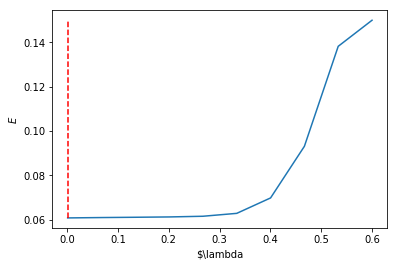

In [111]:
q = 10
lmax = 1
lambda_list = lmax*np.linspace(.6,1e-3,q)
C = X_train.transpose().dot(X_train)
u = X_train.transpose().dot(Y_train)
tau = 1.5/np.linalg.norm(X_train,2)**2

W = np.zeros( (p_in+4,p_out,q) )
E = np.zeros( (q,1) )
w = np.zeros((p_in+4,p_out))
niter = 100
for iq in np.arange(0,q):
    print("Testing ",lambda_list[iq]," (",iq+1,"/",q,")")
    Lambda = lambda_list[iq]
    # ISTA #
    for i in np.arange(0,niter):
        w = ISTA(w,Lambda,tau)
    W[:,:,iq] = w
    E[iq] = Rel_Error(w,w_SS)
# find optimal Lambda
i = E.argmin()
lambda0 = lambda_list[i]
wSparse = W[:,:,i]
# Display error evolution.
plt.clf
plt.plot(lambda_list/lmax, E)
plt.plot( [lambda0/lmax,lambda0/lmax], [E.min(),E.max()], 'r--')
plt.axis('tight')
plt.xlabel('$\lambda')
plt.ylabel('$E$')

# IV. Réseau multicouche

## IV.A. *Forward* et *Backward* step.

Essayons de faire **un réseau multicouche** pour améliorer les performances.

Ce que nous voudrions faire est en fait un **réseau de neurones récurrent**. Mais comme tout est codé à la main, nous allons faire un réseau de neurones classique utilisant en entrée les résultats du temps $t-1$ (comme précédemment).

Nous définissons d'abord plusieurs **fonctions d'activation** utilisable dans le réseau : *arctan*, *ReLu*, l'*identité*  et *$\sigma$ la sigmoide*.

In [112]:
def arctan(u): return 1.5*np.arctan(u)
def arctan_der(u): return 1.5/(1+u**2)

def ReLu(u) : return np.maximum(u,0)
def ReLu_der(u):
    u[u<=0] = 0
    u[u>0] = 1
    return u

def identity(u) : return u
def identity_der(u) : return 1


lambd = 0.1
def sigmoid(u): return 1/(1+np.exp(-lambd*u))
def sigmoid_der(u): return lambd*(sigmoid(u))*(1-sigmoid(u))

# Pour que la sigmoide soit entre -2 et 2:
def sigmoidNorm(u): return 4*(sigmoid(u)-0.5)
def sigmoidNorm_der(u) : return 4*sigmoid_der(u)

Notre réseau n'aura qu'une couche cachée de **20 neurones**. On prend une matrice $A$ pour les poids et $b$ pour le biais.

In [113]:
D = np.array([p_in+4,20,p_out]) # here a single hidden layer
R = D.size-1 
A = []
b = []
for r in np.arange(0,R):
    A.append(np.random.randn(D[r+1],D[r]))
    b.append(np.random.randn(D[r+1],1))

La fonction de **Forward** dans le réseau de neurones, étant donnés les poids $A$, le biais $b$, les données $Z$, et les fonctions d'**activation** $F$.

In [114]:
def ForwardNN(A,b,Z,R,F):
    X = []
    X.append(Z)
    for r in np.arange(0,R):
        f = F[r]
        X.append(f( np.dot(A[r],X[r]) + np.tile(b[r],[1,Z.shape[1]]) ) )
    return np.array(X)



On définit ensuite l'étape **Backward**, qui calcule le gradient par rapport à chaque couche en partant de la fin.

In [115]:
def lossG(Ypred,Y):
    return (Ypred-Y)

def lossF(Ypred,Y):
    return (1/2)*(np.square(Ypred-Y)).mean()

#  convert to a column vector
def MakeCol(y): return y.reshape(-1,1)
#  convert to a row vector
def MakeRow(y): return y.reshape(1,-1)
# find non zero/true elements
def find(x): return np.nonzero(x)[0]

lRidge = 0.2

def BackwardNN(A,b,X,R,Y_train,Fg):
    gA = [] # gradient with respect to A
    gb = [] # gradient with respect to b
    for r in np.arange(0,R):
        gA.append([]) 
        gb.append([])
    gx = lossG(X[R],Y_train.transpose()) # initialize the gradient
    for r in np.arange(R-1,-1,-1):
        in_f = (A[r].dot(X[r]))# + np.tile(b[r],[1,n_train]))
        fg = Fg[r]
        M = fg(in_f)* gx
        # nabla_X[r] 
        gx = A[r].transpose().dot(M)
        # nabla_A[r]
        gA[r] =  M.dot(X[r].transpose()) #+ lRidge*A[r]
        # nabla_b[r]
        gb[r] =  MakeCol(M.sum(axis=1)) + lRidge*b[r]
    return [gA,gb]


Enfin, on définit une étape entière de *ForwardBackard*.

## IV.B. Descente de gradient

J'ai fait plusieurs expériences avec **différentes fonctions d'activation**, j'ai ici choisi de présenter les résultats pour *ReLu* sur la première couche et *arctan* sur la deuxième. On voit que la *loss* diminue au fur et à mesure des epochs, ce qui -a priori- est bon signe.

Final loss :[0.04881457]


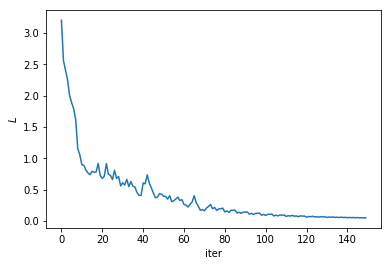

In [116]:

    
def ForwardBackwardNN(A,b,F,X_train,Y_train,Fg):
    Xfwd = ForwardNN(A,b,X_train.transpose(),R,F)
    Lss = lossF(Xfwd[R],Y_train.transpose())
    [gA,gB] = BackwardNN(A,b,Xfwd,R,Y_train,Fg)
    return [Lss,gA,gB]

tau = 10**(-6)
niter = 150
F = [ReLu,arctan]
Fg = [ReLu_der,arctan_der]
L = np.zeros((niter,1))
for it in np.arange(0,niter):
    [L[it],gA,gB] = ForwardBackwardNN(A,b,F,X_train,Y_train,Fg)
    for r in np.arange(0,R):
        A[r] = A[r] - tau*gA[r]
        b[r] = b[r] - tau*gB[r]
plt.clf
plt.plot(L)
plt.xlabel('iter')
plt.ylabel('$L$')
plt.axis('tight')
print("Final loss :"+str(L[-1]))

Cependant, le réseau est entraîné avec les valeurs exactes de la sortie au temps $t-1$. Si on utilise les prédictions, le résultat est **très décevant**.

SESSION  29


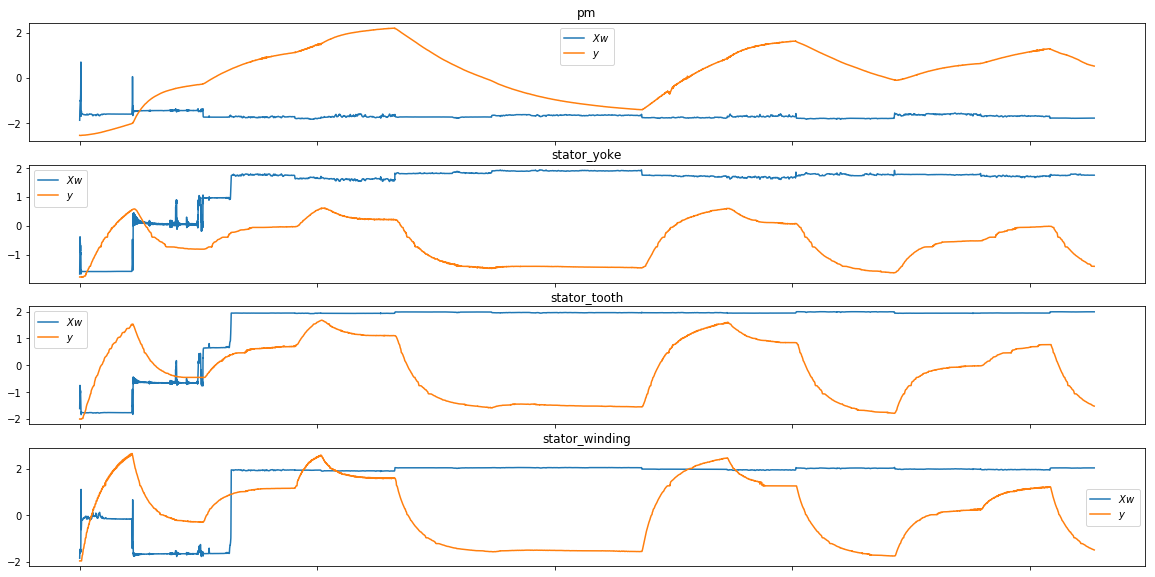

In [117]:

sess_test = np.random.choice(Itest,1)
data_sess = get_session(X,sess_test)
X_test_sess = data_sess[:,x_att]
#X_test_sess = np.concatenate([np.ones((len(X_test_sess),1)),X_test_sess],axis=1)
Y_test_sess = data_sess[:,y_att]
plt.clf
plt.figure(figsize=(20,10))
print("SESSION ",int(sess_test[0]))
Y_pred =  [np.array([X_test_sess[0,1],1]).dot(w_SS)]
for i in range(len(X_test_sess)):
    if i >= 0:
        X_in = np.concatenate([Y_pred[-1],X_test_sess[i]])
    else:
        X_in = np.concatenate([Y_test_sess[i-1],X_test_sess[i]])
        
    X_out = ForwardNN(A,b,X_in[:,np.newaxis],R,F)
    Y_pred.append(X_out[R].transpose()[0])

Y_pred = np.array(Y_pred)

for i in range(p_out):
    plt.subplot(p_out,1,i+1)
    plt.plot(Y_pred[offset:,i], '-' )
    plt.plot( Y_test_sess[:,i], '-' )
    plt.title(Xlabels[y_att[i]])
    plt.axis('tight')
    plt.tick_params(axis='x', labelbottom=False)
    plt.legend(['$X w$','$y$']);
    

En effet, comme on peut le voir ci-dessous, où sont affichés **les poids des entrées pour chaque neurone de la couche cachée**, toutes les entrées ont un poids **à peu près équivalent**, alors que le poids des 4 premières entrées (prédiction au temps $t-1$) devrait avoir un poids beaucoup plus grand. Cela explique en partie pourquoi, sur le graphique ci-dessus, les prédictions subissent de très fortes variations.

Couche cachée


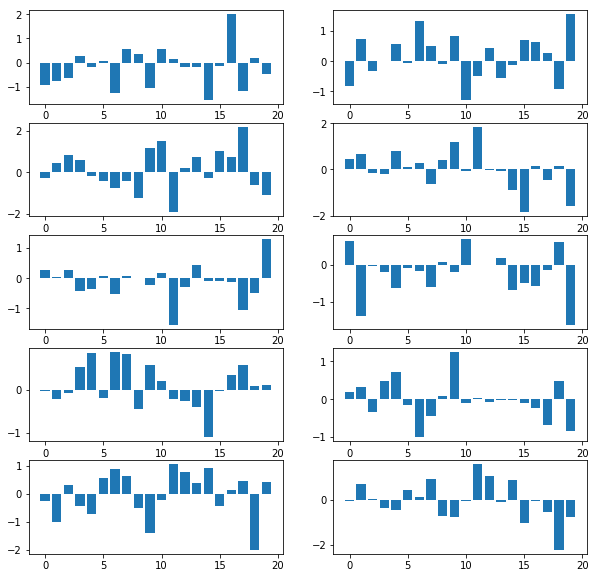

In [118]:
plt.clf
print("Couche cachée")
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.bar(np.arange(len(A[0])), (A[0][:,i]))
 




## IV.C. Descente de gradient stochastique

Essayons à nouveau en appliquant cette fois la méthode de **Descente de Gradient Stochastique** sur des *minis batchs* (par exemple des batchs de taille $32$). J'ai également ajouté une régularisation *Ridge* avec un facteur différent pour les poids et pour le biais. La *loss* sur les exemples d'entraînement est plus faible que pour la descente de gradient classique, et en plus **elle converge plus vite**. Cependant, le problème vu précédemment persiste, et notre modèle est **incapable de prédire correctement l'évolution du système**.

In [119]:
A = []
b = []
for r in np.arange(0,R):
    A.append(np.random.randn(D[r+1],D[r]))
    b.append(np.random.randn(D[r+1],1))

Final Loss : [0.01661321]


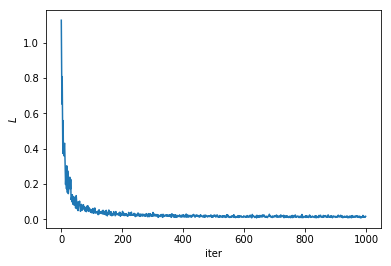

In [120]:
tau = 10**(-2)
niter = 1000
F = [ReLu,sigmoidNorm]
Fg = [ReLu_der,sigmoidNorm_der]
L = np.zeros((niter,1))
for it in np.arange(0,niter):
    ind_it = np.random.choice(np.arange(len(X_train)),32)
    X_train_it = X_train[ind_it]
    Y_train_it = Y_train[ind_it]
    [L[it],gA,gB] = ForwardBackwardNN(A,b,F,X_train_it,Y_train_it,Fg)
    for r in np.arange(0,R):
        A[r] = A[r] - tau*(gA[r] + 0.1*A[r]) #Régularisation
        b[r] = b[r] - tau*(gB[r] + 100*b[r])
plt.clf
plt.plot(L)
plt.xlabel('iter')
plt.ylabel('$L$')
plt.axis('tight')
print("Final Loss : "+str(L[-1]))

SESSION  66


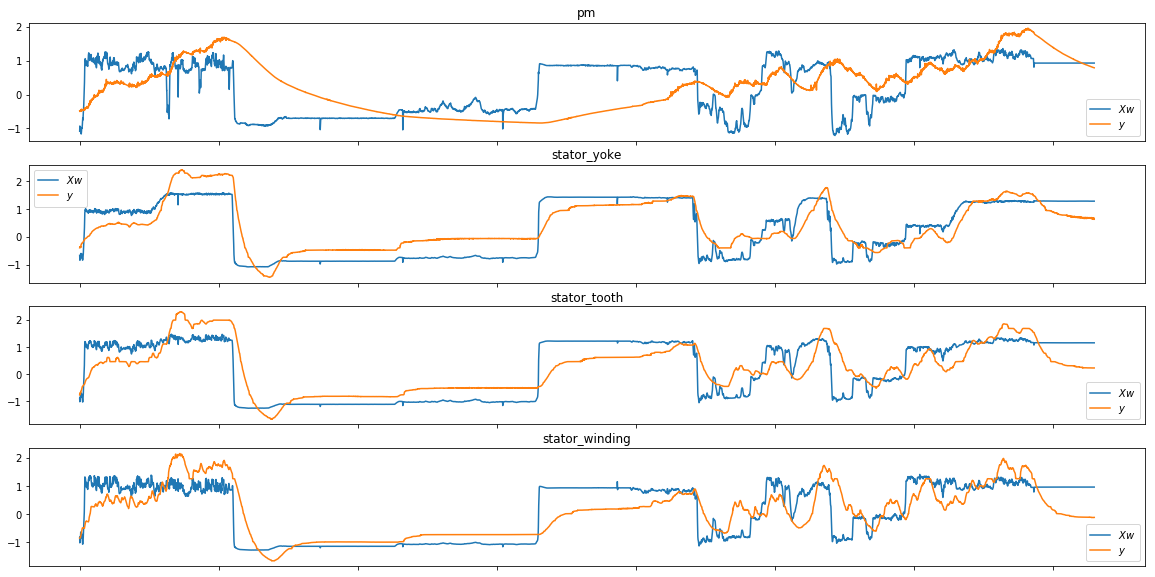

In [121]:

sess_test = np.random.choice(Itest,1)
data_sess = get_session(X,sess_test)
X_test_sess = data_sess[:,x_att]
#X_test_sess = np.concatenate([np.ones((len(X_test_sess),1)),X_test_sess],axis=1)
Y_test_sess = data_sess[:,y_att]
plt.clf
plt.figure(figsize=(20,10))
print("SESSION ",int(sess_test[0]))
Y_pred =  [np.array([X_test_sess[0,1],1]).dot(w_SS)]
for i in range(len(X_test_sess)):
    if i >= 0:
        X_in = np.concatenate([Y_pred[-1],X_test_sess[i]])
    else:
        X_in = np.concatenate([Y_test_sess[i-1],X_test_sess[i]])
        
    X_out = ForwardNN(A,b,X_in[:,np.newaxis],R,F)
    Y_pred.append(X_out[R].transpose()[0])

Y_pred = np.array(Y_pred)

for i in range(p_out):
    plt.subplot(p_out,1,i+1)
    plt.plot(Y_pred[offset:,i], '-' )
    plt.plot( Y_test_sess[:,i], '-' )
    plt.title(Xlabels[y_att[i]])
    plt.axis('tight')
    plt.tick_params(axis='x', labelbottom=False)
    plt.legend(['$X w$','$y$']);

## IV.D. Avec plein de couches !

Que se passe t-il avec **3 couches cachées** ?

Malheureusement, cela ne marche toujours pas... (même si la *loss* est encore meilleure).

Final Loss : [0.01138491]


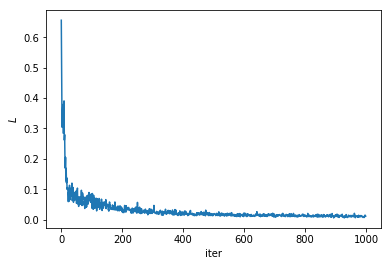

In [122]:
D = np.array([p_in+4,8,16,8,p_out]) # here a single hidden layer
R = D.size-1 
A = []
b = []
for r in np.arange(0,R):
    A.append(np.random.randn(D[r+1],D[r]))
    b.append(np.random.randn(D[r+1],1))
    
F = [ReLu,ReLu,ReLu,sigmoidNorm]
Fg = [ReLu_der,ReLu_der,ReLu_der,sigmoidNorm_der]

#F = [identity,identity,identity,sigmoidNorm]
#Fg = [identity_der,identity_der,identity_der,sigmoidNorm_der]
tau = 10**(-2)
niter = 1000
L = np.zeros((niter,1))
for it in np.arange(0,niter):
    ind_it = np.random.choice(np.arange(len(X_train)),32)
    X_train_it = X_train[ind_it]
    Y_train_it = Y_train[ind_it]
    [L[it],gA,gB] = ForwardBackwardNN(A,b,F,X_train_it,Y_train_it,Fg)
    for r in np.arange(0,R):
        A[r] = A[r] - tau*(gA[r] + 0.1*A[r]) #Régularisation
        b[r] = b[r] - tau*(gB[r] + 100*b[r])
plt.clf
plt.plot(L)
plt.xlabel('iter')
plt.ylabel('$L$')
plt.axis('tight')
print("Final Loss : "+str(L[-1]))

SESSION  54


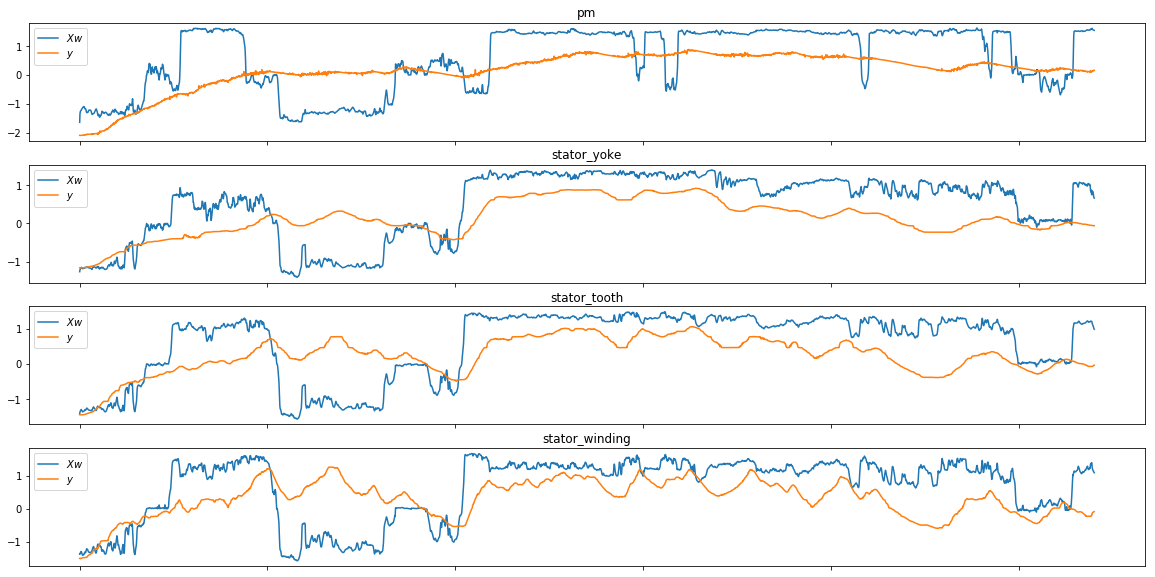

In [123]:
sess_test = np.random.choice(Itest,1)
data_sess = get_session(X,sess_test)
X_test_sess = data_sess[:,x_att]
#X_test_sess = np.concatenate([np.ones((len(X_test_sess),1)),X_test_sess],axis=1)
Y_test_sess = data_sess[:,y_att]
plt.clf
plt.figure(figsize=(20,10))
print("SESSION ",int(sess_test[0]))
Y_pred =  [np.array([X_test_sess[0,1],1]).dot(w_SS)]
for i in range(len(X_test_sess)):
    if i >= 0:
        X_in = np.concatenate([Y_pred[-1],X_test_sess[i]])
    else:
        X_in = np.concatenate([Y_test_sess[i-1],X_test_sess[i]])
        
    X_out = ForwardNN(A,b,X_in[:,np.newaxis],R,F)
    Y_pred.append(X_out[R].transpose()[0])

Y_pred = np.array(Y_pred)

for i in range(p_out):
    plt.subplot(p_out,1,i+1)
    plt.plot(Y_pred[offset:,i], '-' )
    plt.plot( Y_test_sess[:,i], '-' )
    plt.title(Xlabels[y_att[i]])
    plt.axis('tight')
    plt.tick_params(axis='x', labelbottom=False)
    plt.legend(['$X w$','$y$']);

Il semblerait que la piste des **réseaux de neurones profonds** ne soit pas envisageable pour résoudre ce problème, car les modèles sont trop complexes. En plus de cela, nous obtenons déjà des résultats **très satisfaisants** avec des simples modèles (voir plus haut). Je voulais essayer brièvemment d'utiliser le *momentum*, mais je suis convaincu que ça n'améliorera pas notre problème.

# CONCLUSION

Pour conclure, j'ai trouvé ce projet **Très intéressant** car il m'a permis d'appliquer de nombreuses méthodes vues en cours (Régression, régularisation, descente de gradient, méthodes stochastiques, momentum, réseau multicouche, etc.) à un problème concret qui est celui de prédire la température d'un moteur électrique.

Malgré les mauvais résultats **du réseau multicouche**, une **régression simple** avec régularisation *Ridge* et utilisant les prédictions du temps $t-1$ (avec une initialisation correcte) apparaît très efficace et très probablement utilisable en situation réelle pour détecter les cas de surchauffe du moteur.

